In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import math

### load data function

In [3]:


def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [4]:
#add salt and pepper noise function
def salt_pepper_noise(image, salt = True, pepper = False, noise_level=0.05):

    #set dimensions
    out_image = image.copy()
    orginal_dims = out_image.shape[0]

    #set percentage noise
    num_noise_pixels = int(orginal_dims*noise_level)

    if pepper:
        #add black points
        black_points = random.sample(range(orginal_dims), k=num_noise_pixels)

        #add black dots to image
        out_image[black_points] = 0

    if salt:
        #white points
        white_points = random.sample(range(orginal_dims), k=num_noise_pixels)

        #add white points to images
        out_image[white_points] = 255

    return out_image

## Euclidean multiplicative update alogrithm

In [5]:
"""
https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf
V = WH

W = (n x r) matrix
H = (r x m) matrix

cost function SSE = sum(V-WH)**2

multiplicative update rules
 H = H*(W.T@V)/(W.T@W@H)
 W = W(V@H.T)/(W@H@HT)
 
 check error
 
 itterate

"""

def euclidean_multiplicative_update (V, r, iteration):
    
    loss = []
    W = np.random.rand(V.shape[0],r)*255
    H = np.random.rand(r,V.shape[1])*255
    
    for i in range(iteration):
        H = H*(W.T@V)/(W.T@W@H)
        W = W*(V@H.T)/(W@H@H.T)
        l = np.sum((V-W@H)**2)
        loss.append(l)
        
    return W, H, loss        


In [6]:
'''
https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf
implimentation from page 3 formula 5
'''

def KL_divergence_update(V,r,iteration):

    loss = []
    W = np.random.rand(V.shape[0],r)*255
    H = np.random.rand(r,V.shape[1])*255
    
    for i in range(iteration):
        H = H * np.dot(W.T,V / np.dot(W,H)) / np.sum(W,0)[:,None]
        W = W * np.dot(V / np.dot(W,H),H.T) / np.sum(H,1)
        l=np.sum(V*np.log((V++1e-10)/(W@H))-V+(W@H))
        loss.append(l)
        
    return W, H, loss 
    

## Algorithm: NMF with L1 sparseness constraints

In [30]:
def hoyers_projection(x, L1_constraint):
    
    #determine parameters
    n = len(x)
    L1 = np.sum(abs(x))
    L2 = np.sum(x**2) 
    e = np.ones(n)
    x=abs(x)
    
    #zero coefficients
    zero_coeff = []
    
    s = x+(L1_constraint-L1)/(n) 
    
    s = s.flatten()

    n_iter = 0
    
    while True:
        
        #set zero coefficents in mid point to zero 
        #mid point
        m = np.ones(n)*L1_constraint/(n-len(zero_coeff))
        m[zero_coeff] = 0
        w = s-m
        w_T = w.T
        a = np.sum(w**2)
        b = (s@w_T)*2
        c = np.sum(s**2)-L2

        #solve quadratic
        alpha = (-b+math.sqrt(b**2-4*a*c))/(2*a)

        s = alpha*w + s
        
        if (s>=0).all():
            n_iter += 1
            break

        n_iter += 1
        
        negatives = np.where(s<=0)[0]
        
        negatives = [i for i in negatives if i not in zero_coeff]
        
        zero_coeff.extend(negatives)
        #zero_coeff= np.unique(zero_coeff)
        
        s[zero_coeff] = 0
        
        tempsum = sum(s)
        
        s = s + (L1_constraint-tempsum)/(n-len(zero_coeff))
        
        s[zero_coeff] = 0
        
        if n_iter == n:
            break
                
    return s, n_iter


In [442]:
def NMFS(V,r,Hs,Ws,muH,muW, iterations):
    
    '''
    algorithm based on this paper 
    http://jmlr.csail.mit.edu/papers/volume5/hoyer04a/hoyer04a.pdf
    '''
    
    #Hs set sparesness of H between [0:1]
    #Ws set sparesness of W between [0:1]
    #r new dimension
    #muH step size for gradient descent
    #muW step size for gradient descent
    
    #shape of input matrix
    m = V.shape[0]
    n = V.shape[1]
    V=V
    
    #set error
    error = []

    #randomly intialise W & H
    W = np.random.rand(V.shape[0],r)*255
    H = np.random.rand(r,V.shape[1])*255
    H = H/np.linalg.norm(H.T, axis=1)
    
    #set intial error
    l = np.sum((V-W@H)**2)
    error.append(l)
    
    print('Processing intial W and H')
       
    #If sparseness constraints on W apply, then project each column of W to be non-negative, have
    #unchanged L2 norm, but L1 norm set to achieve desired sparseness
    if Ws is not None:
        L1a = (math.sqrt(m)-(math.sqrt(m)-1)*Ws)
        for i in range(0,r):
            W[:,i] = hoyers_projection(W[:,i],L1a*np.linalg.norm(W[:,i]))[0]
        print('Processing intial W complete')
           
    
     #If sparseness constraints on H apply, then project each row of H to be non-negative, have unit
     #L2 norm, and L1 norm set to achieve desired sparseness
    if Hs is not None:
        
        L1s = math.sqrt(n)-(math.sqrt(n)-1)*Hs 
        for i in range(0,r):
            H[i,:] = hoyers_projection(H[i,:],L1s*np.linalg.norm(H[i,:]))[0]
        print('Processing intial H complete')
            
    Wold = W
    Hold = H
    
    for x in range(0,iterations):
    
        #Iterate
        if x % 10 == 0:
            print('Processing iteration ', x)


         #If sparseness constraints on H apply,
            #i. Set H := H−µHWT(WH−V)
            #ii. Project each row of H to be non-negative, have unit L2 norm, and L1 norm set to achieve desired sparseness
            #else take standard multiplicative step H := H⊗(WTV)/(WTWH)
        if Hs is not None:
            
            #set beginning objective
            begobj = np.sum((V-W@H)**2)
            gradient = (W.T@(W@H-V))

            while True:
                Hnew = H-muH*gradient
                for i in range(0,r):
                    Hnew[i,:] = hoyers_projection(Hnew[i,:],L1s*np.linalg.norm(Hnew[i,:]))[0]
                
                #Calculate new objective 
                newobj = np.sum((V-W@Hnew)**2)
                
                if newobj <= begobj:
                    break
                
                else:
                    #reduce step size
                    #print('reducing step size')
                    muH = muH/2
                    
                
            #increase step size 
            muH = muH*1.2
            H = Hnew
        
        
        #else normal multiplicative update
        else:
            H = H*(W.T@V)/(W.T@W@H)
            
        
        
        #If sparseness constraints on W apply,
            #i. Set W := W−µW(WH−V)HT
            #ii. Project each column of W to be non-negative, have unchanged L2 norm, but L1
            #norm set to achieve desired sparseness
            #else take standard multiplicative step W := W⊗(VHT)/(WHHT)

        
        if Ws is not None:
            
            #set beginning objective
            begobj = np.sum((V-W@H)**2)
            gradient = ((W@H-V)@(H.T))
                #set_trace()
            
            while True:
                
                #update W and apply constraint
                Wnew = W-muW*gradient
                for i in range(0,r):
                    Wnew[:,i] = hoyers_projection(Wnew[:,i],L1a*np.linalg.norm(Wnew[:,i]))[0]
                
                #Calculate new objective 
                newobj = np.sum((V-Wnew@H)**2)
                
                if newobj <= begobj:
                    #print('objective reduced')
                    break
                
                else:
                    #reduce step size
                    #print('reducing step size')
                    muW = muW/2

                
            #increase step size
            muW = muW*1.2
            W = Wnew
                
        else:        
            W = W*(V@H.T)/(W@H@H.T)


        l = np.sum((V-W@H)**2)
        error.append(l)
        
        if muH < 1e-150 or muW < 1e-150:
            print('Algorithm converged at iteration', x)
            return W,H, error
            
    return W,H, error

## Load datasets

In [223]:
ORL_REDUCE = 3
YALEB_REDUCE = 4

# Load ORL dataset.
ORL_IMGS, ORL_LABELS = load_data(root='data/ORL', reduce=ORL_REDUCE)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(ORL_IMGS.shape, ORL_LABELS.shape))

# Load Extended YaleB dataset.
YALEB_IMGS, YALEB_LABELS = load_data(root='data/CroppedYaleB', reduce=YALEB_REDUCE)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(YALEB_IMGS.shape, YALEB_LABELS.shape))

ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


In [224]:
ORL_WIDTH = 92
ORL_HEIGHT = 112
YALEB_WIDTH = 168
YALEB_HEIGHT = 192

In [225]:
print('ORL dataset resolution: Width = {}, Height = {}'.
      format(ORL_WIDTH//ORL_REDUCE, ORL_HEIGHT//ORL_REDUCE))
print('Extended YalB dataset dataset resolution: Width = {}, Height = {}'.
      format(YALEB_WIDTH//YALEB_REDUCE, YALEB_HEIGHT//YALEB_REDUCE))

ORL dataset resolution: Width = 30, Height = 37
Extended YalB dataset dataset resolution: Width = 42, Height = 48


In [226]:
ORL_DIMS = (int(112/ORL_REDUCE),int(92/ORL_REDUCE))
YALEB_DIMS = (int(192/YALEB_REDUCE),int(168/YALEB_REDUCE))
print(ORL_DIMS)
print(YALEB_DIMS)

(37, 30)
(48, 42)


In [10]:
# Load ORL dataset.
X, Y = load_data(root='data/ORL', reduce=1)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

ORL dataset: X.shape = (10304, 400), Y.shape = (400,)


## Analysis using euclidean updates

In [10]:
W, H, loss  = euclidean_multiplicative_update(X, 10, 300)

300


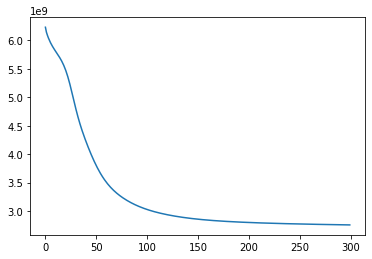

In [11]:
print(len(loss))
plt.plot(range(0,len(loss)),loss)

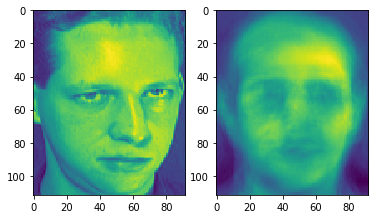

In [38]:
#view image then view recreation
recon = W@H
f, axarr = plt.subplots(1,2)
axarr[0].imshow(X[:,1].reshape(orldims))
axarr[1].imshow(recon[:,1].reshape(orldims))

## Analysis using KL divergence update

In [39]:
#run MNF using KL divergence 
W, H, loss  = KL_divergence_update(X, 10, 300)

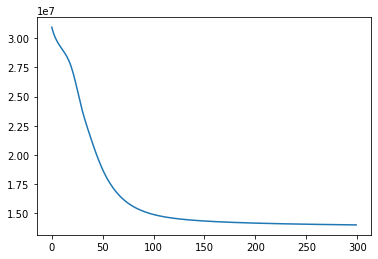

In [40]:
plt.plot(range(0,len(loss)),loss)

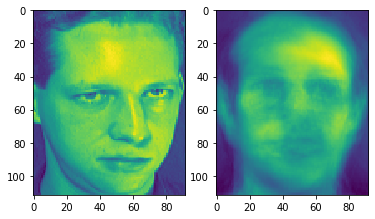

In [41]:
recon = W@H
f, axarr = plt.subplots(1,2)
axarr[0].imshow(X[:,1].reshape(orldims))
axarr[1].imshow(recon[:,1].reshape(orldims))

## Analysis using L1 sparseness

In [421]:
%%time

#create smaller dataset 
X_1 = ORL_IMGS[:,0:150]

#NMFS2(V,r,Hs,Ws,muH,muW, iterations)
Wnew,Hnew, error = NMFS(ORL_IMGS,10,None,0.2,1,1,1000)


Processing intial W and H
Processing intial W complete
Processing iteration  0
Processing iteration  100
Processing iteration  200
Processing iteration  300
Processing iteration  400
Processing iteration  500
Processing iteration  600
Processing iteration  700
Processing iteration  800
Processing iteration  900
Wall time: 1min 41s


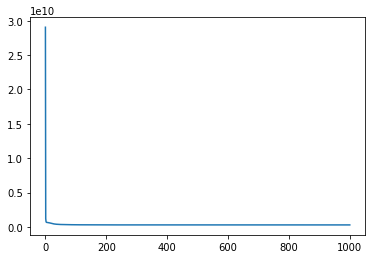

In [423]:
plt.plot(range(0,len(error)),error)

In [424]:
recon1 =Wnew@Hnew

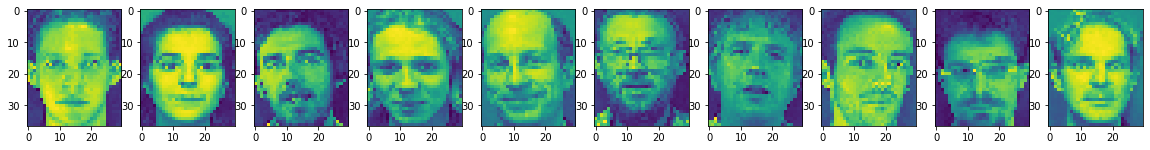

In [436]:
plt.figure(figsize=(20, 4))
images = 10
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(X_1[:,i*11].reshape(ORL_DIMS))

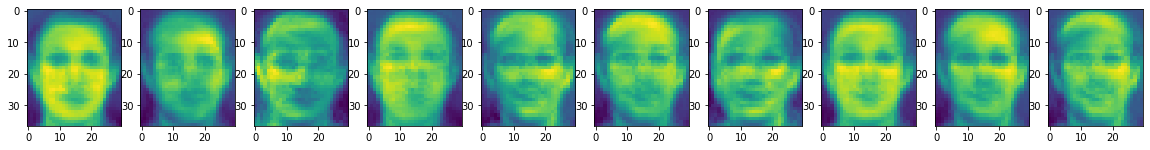

In [425]:
plt.figure(figsize=(20, 4))
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(recon1[:,i*11].reshape(ORL_DIMS))

## Add noise 

In [426]:
def add_block_occlusion(image, bsize=(4,4), dims=None, seed=1, n_boxes=1):

    to_return = image.copy()
    origidims = to_return.shape
    np.random.seed(seed)
    if dims==None: raise ValueError("dimensions must be provided")
        
    to_return = to_return.reshape(dims[0], dims[1])
    
    for b in range (n_boxes):
        xpoint = np.random.choice(range(dims[0] - bsize[0]), 1)[0]
        ypoint = np.random.choice(range(dims[1] - bsize[1]), 1)[0]

        for x in range(xpoint, xpoint+bsize[0]):
            for y in range(ypoint, ypoint+bsize[1]):
                to_return[x,y] = 255
    
    to_return = to_return.reshape(origidims)
    return to_return

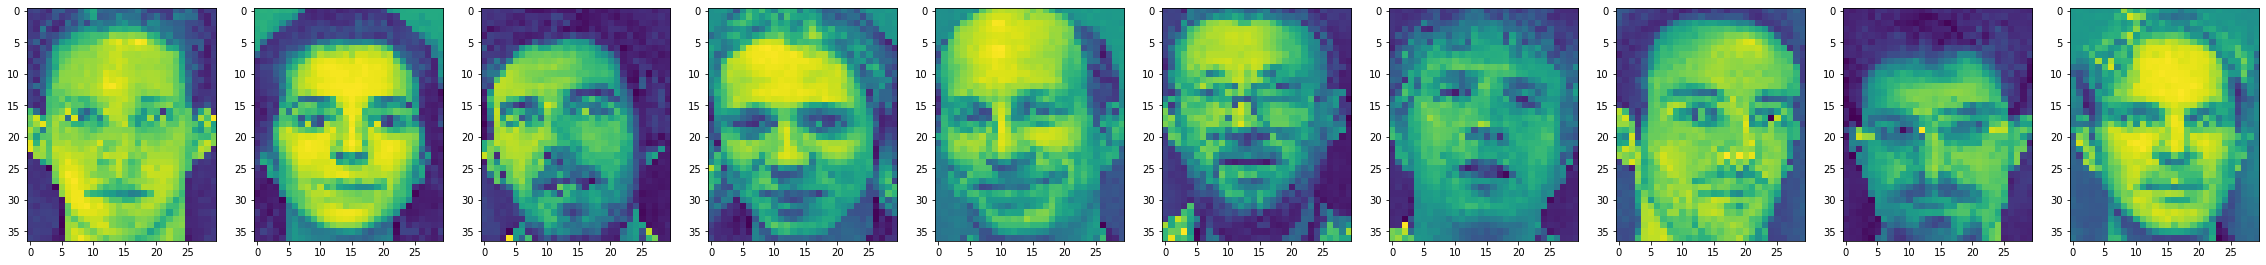

In [428]:
ORL_IMGS_LST = [ORL_IMGS[:,i] for i in range(ORL_IMGS.shape[1])]
plt.figure(figsize=(40, 8))
images = 10
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(ORL_IMGS_LST[i*11].reshape(ORL_DIMS))

In [429]:
# Adding occlusion blocks to ORL images
ORL_IMGS_OCCL = np.array(
    [
        add_block_occlusion(image,
                            bsize=(ORL_DIMS[0]//6,
                                   ORL_DIMS[1]//6), 
                            dims=ORL_DIMS, 
                            seed=np.random.choice(range(1000)),
                            n_boxes=4) 
     for image in ORL_IMGS_LST]).T

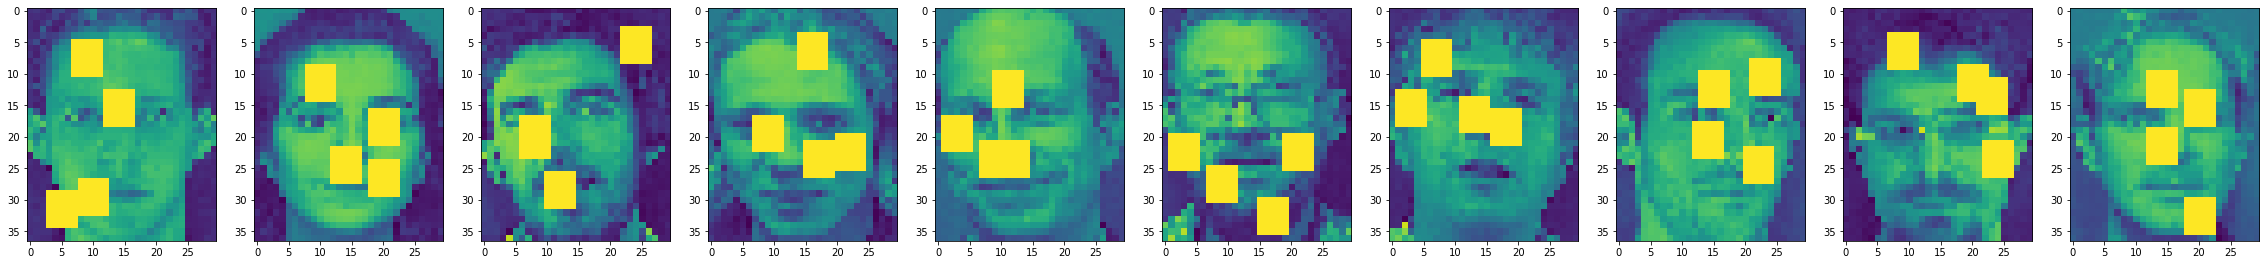

In [430]:
plt.figure(figsize=(40, 8))
images = 10
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(ORL_IMGS_OCCL[:,i*11].reshape(ORL_DIMS))

Processing intial W and H
Processing intial W complete
Processing iteration  0
Processing iteration  100
Processing iteration  200
Processing iteration  300
Processing iteration  400
Processing iteration  500
Processing iteration  600
Processing iteration  700
Processing iteration  800
Processing iteration  900


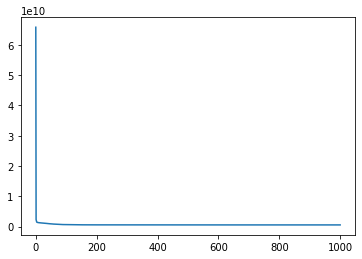

In [434]:
#NMFS2(V,r,Hs,Ws,muH,muW, iterations)
Wnew,Hnew, error = NMFS(ORL_IMGS_OCCL,20,None,0.5,1,1,1000)
plt.plot(range(0,len(error)),error)

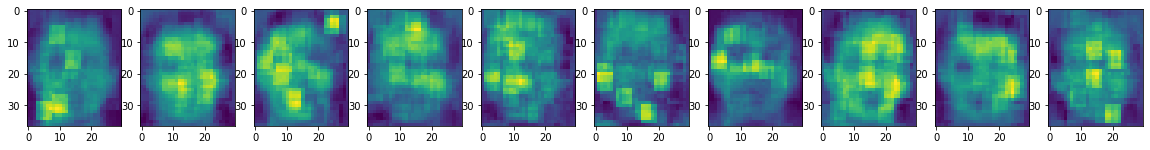

In [435]:
recon2 =Wnew@Hnew
plt.figure(figsize=(20, 4))
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(recon2[:,i*11].reshape(ORL_DIMS))

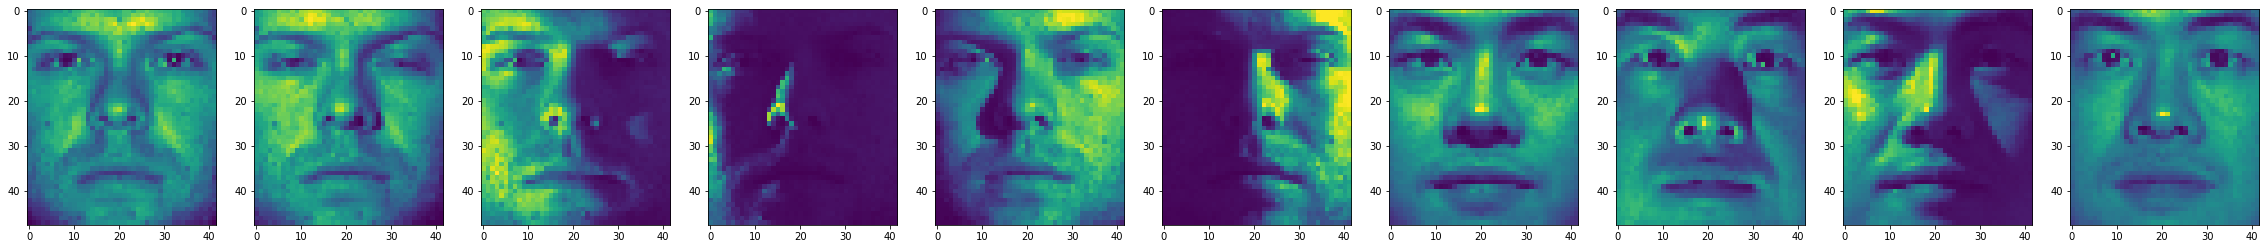

In [437]:
YALEB_IMGS_LST = [YALEB_IMGS[:,i] for i in range(YALEB_IMGS.shape[1])]
plt.figure(figsize=(40, 8))
images = 10
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(YALEB_IMGS_LST[i*11].reshape(YALEB_DIMS))

In [438]:
# Adding occlusion blocks to YaleB images
YALEB_IMGS_OCCL = np.array(
    [
        add_block_occlusion(image,
                            bsize=(YALEB_DIMS[0]//6,
                                   YALEB_DIMS[1]//6), 
                            dims=YALEB_DIMS, 
                            seed=np.random.choice(range(1000)),
                            n_boxes=4) 
     for image in YALEB_IMGS_LST]).T

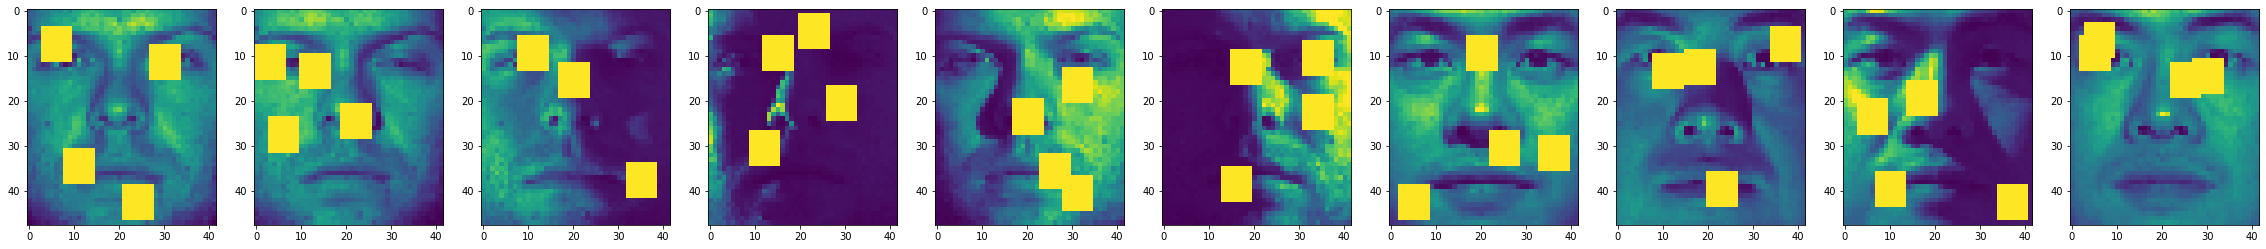

In [439]:
plt.figure(figsize=(40, 8))
images = 10
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(YALEB_IMGS_OCCL[:,i*11].reshape(YALEB_DIMS))

Processing intial W and H
Processing intial W complete
Processing iteration  0
Processing iteration  10
Processing iteration  20
Processing iteration  30
Processing iteration  40
Processing iteration  50
Processing iteration  60
Processing iteration  70
Processing iteration  80
Processing iteration  90


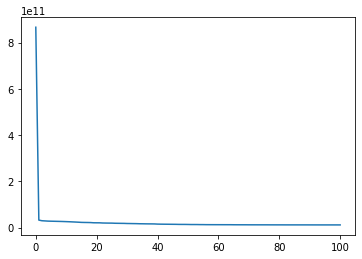

In [450]:
#NMFS2(V,r,Hs,Ws,muH,muW, iterations)
Wnew,Hnew, error = NMFS(YALEB_IMGS_OCCL,20,0.2,0.6,1,1,100)
plt.plot(range(0,len(error)),error)

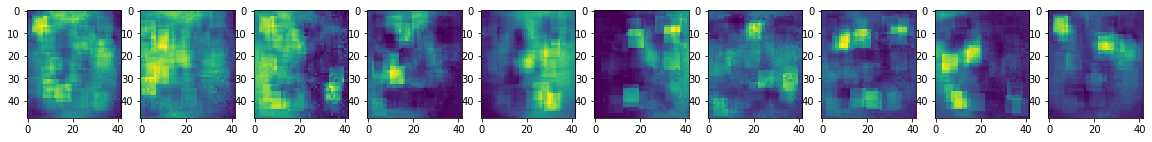

In [451]:
recon3 =Wnew@Hnew
plt.figure(figsize=(20, 4))
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(recon3[:,i*11].reshape(YALEB_DIMS))

## Add clean images 

Processing intial W and H
Processing intial W complete
Processing intial H complete
Processing iteration  0
Processing iteration  10
Processing iteration  20


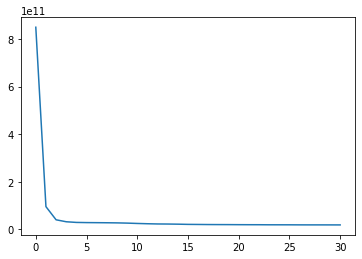

In [484]:
YALEB_NEW = np.append(YALEB_IMGS_OCCL,YALEB_IMGS, axis = 1)
#NMFS2(V,r,Hs,Ws,muH,muW, iterations)
Wnew,Hnew, error = NMFS(YALEB_IMGS_OCCL,20,0.3,0.2,1,1,30)
plt.plot(range(0,len(error)),error)

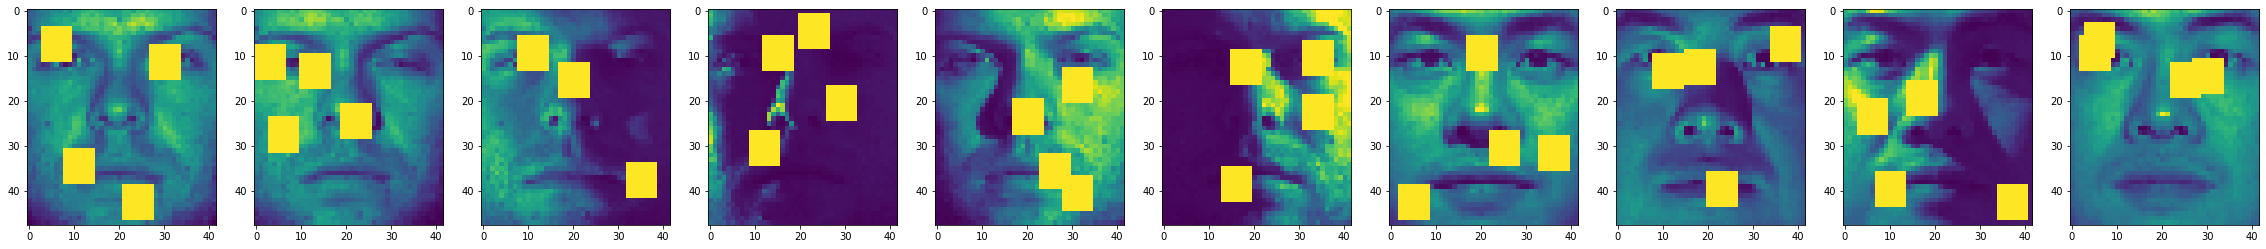

In [474]:
plt.figure(figsize=(40, 8))
images = 10
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(YALEB_NEW[:,i*11].reshape(YALEB_DIMS))

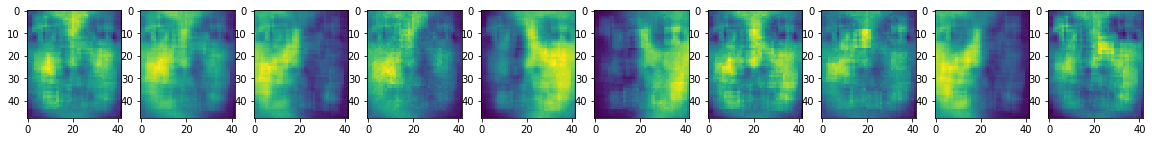

In [483]:
recon4 =Wnew@Hnew
plt.figure(figsize=(20, 4))
for i in range(images):
    plt.subplot(1, images, i+1)
    plt.imshow(recon4[:,i*11].reshape(YALEB_DIMS))